In [808]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Dataset**

The ‘TennisAbstract’ website and its associated blog ‘Heavy Topspin’ are resources made available for free by tennis enthusiast Jeff Sackmann. The source is widely referenced in both academic papers (Kovalchik Stephanie, 2016) and in less formal analyses by members of the tennis community and is regularly maintained. The raw data that they link to contains 
information on all ATP tournaments going all the way back to 1968 (start of the open era) in an easily downloadable format and contains the following fields:

In [809]:
''' 

Function to import data from github. Date range must be valid per the given URL

'''

def import_data(start_date: int, end_date: int):
    li = []
    for year in range(start_date, end_date, 1):
        url = f'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/refs/heads/master/atp_matches_{year}.csv'
        data = pd.read_csv(url, header=0)

        li.append(data)

    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

In [810]:
df = import_data(2010, 2019)
print('Shape:', df.shape)
df.head(5)

Shape: (26591, 49)


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2010-339,Brisbane,Hard,32,A,20100103,1,104053,1.0,NaN,...,34.0,29.0,11.0,10.0,3.0,5.0,7.0,4410.0,77.0,598.0
1,2010-339,Brisbane,Hard,32,A,20100103,2,104958,NaN,WC,...,34.0,22.0,14.0,9.0,7.0,10.0,134.0,400.0,78.0,590.0
2,2010-339,Brisbane,Hard,32,A,20100103,3,104755,NaN,NaN,...,58.0,38.0,14.0,14.0,7.0,11.0,52.0,850.0,88.0,568.0
3,2010-339,Brisbane,Hard,32,A,20100103,4,105051,NaN,Q,...,29.0,16.0,15.0,9.0,2.0,5.0,285.0,151.0,28.0,1260.0
4,2010-339,Brisbane,Hard,32,A,20100103,5,104607,4.0,NaN,...,41.0,26.0,14.0,9.0,6.0,9.0,20.0,1655.0,251.0,179.0


**Basic data cleaning**

The following actions were taken to clean the data ahead of analysis:

•   Dates were standardized using the datetime package.

•   Matches with empty data fields were removed.

•   Abandoned matches were removed by deleting games with fewer than 24 service points from winner and loser.

•   Matches with missing ‘handedness’ were removed

•   Missing height data was replaced with average height for winner / loser. This is clearly a large assumption but with so many players not having any height data the alternative was to remove them all and it was felt that this would remove too much valuable information from the dataset.

•   Players with missing age data were removed.

•   Players without rank data were removed.

•   Matches with no surface data were removed

•   Players who had played less than 5 games at ATP level during the study were removed. This was done to address the fact that many of the players on the ATP tour are on the fringes of this level of the game. Places at local tournaments are often secured for local players who are not up to the standard of the other competitors. Players in this category are outliers in the sense that they only manage a handful of games at this level throughout their careers and therefore there is limited data on each of them to have a meaningful impact on a predictive model. The removal of players with fewer than 5 competitive matches at this level over the period of the data is qualitative attempt to ‘clean’ the data of these contributions. 
 


In [811]:

'''
Perform data 'cleaning' operations on raw dataframe. List of transformations can be found 
in the precedint markdown cell but in general the goal is to homogenise the dataframe with a 
goal of modelling contests with similar characteristics
'''


def clean_data(df):
    ### Reformat dates using datetime
    df['tourney_date'] = pd.to_datetime(df['tourney_date'], format='%Y%m%d')
    ### Restrict analysis to hard courts 
    df = df[df['surface'] == 'Hard']
    ### Remove matches with significant missing data (use 'winner aces' here but could use any of missing fields)
    df = df.dropna(subset=['w_ace'])
    ### Remove abandoned matches - fewer than 24 serves.
    df = df[df['w_svpt'].gt(24) | df['l_svpt'].gt(24)]
    ### Remove matches where 'handedness of one or other players is missing or n/a
    df = df.dropna(subset=['winner_hand', 'loser_hand'])
    ### Replace missing height data with average height
    df['loser_ht'] = df['loser_ht'].fillna(df['loser_ht'].mean())
    df['winner_ht'] = df['winner_ht'].fillna(df['winner_ht'].mean())
    ### Remove entries with missing rank data
    df = df.dropna(subset=['winner_rank', 'loser_rank'])
    
    
    return df

df = clean_data(df)

In [812]:
### Replace winner/loser structure with a player1/player2 structure
df['flag'] = np.random.randint(0, 2, df.shape[0])
df['Player1'] = np.where(df['flag'] == 1, df['winner_name'], df['loser_name'])
df['Player2'] = np.where(df['flag'] == 1, df['loser_name'], df['winner_name'])


**Infrequent competitors**

Now consider players who've not played many times over the relevant period...

In [813]:
### Create df of players with their win totals
def player_record(df):
    players = np.union1d(pd.unique(df['winner_name']), pd.unique(df['loser_name']))
    df_matches = pd.DataFrame(['Player', 'W matches', 'L matches', 'Total matches'])
    dict_list = []

    for player in players:
        row_dict = {'Player': player, 
                    'W matches': 0 if player not in df['winner_name'].value_counts() else df['winner_name'].value_counts()[player], 
                    'L matches': 0 if player not in df['loser_name'].value_counts() else df['loser_name'].value_counts()[player],
                    'Total matches': 0
                    }
        dict_list.append(row_dict)
    df_matches = pd.DataFrame.from_dict(dict_list)
    df_matches['Total matches'] = df_matches['W matches'] + df_matches['L matches']

    return df_matches

In [814]:
# list of all playerw with number of matches won / lost / played
record = player_record(df)
record_sub_5 = record.loc[record['Total matches'] < 5, 'Player']
print(f'Players with fewer than 5 matches / total number of players: {len(record_sub_5)/record.shape[0]}')



Players with fewer than 5 matches / total number of players: 0.49786628733997157


Seems a bit high (350 / 703)... but clearly lots of players only play < 5 matches at this level...

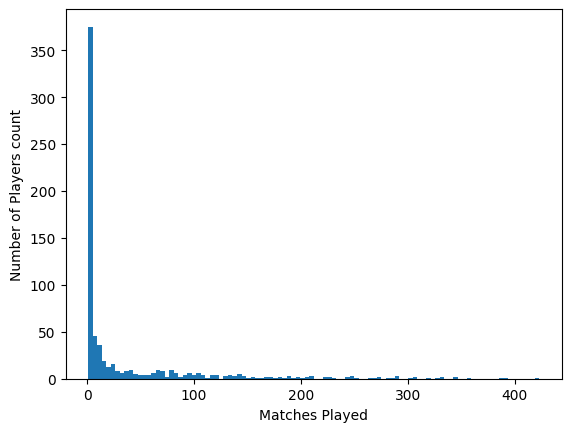

In [815]:
plt.hist(record['Total matches'], bins=100)
plt.ylabel('Number of Players count')
plt.xlabel('Matches Played')
plt.show() 

Let's remove these players from the main dataframe as they're not part of the corpus that we're trying to built a predictive model for.

In [816]:
# list of player names who've played fewer than 5 times on the ATP tour in the given time period
sub_5_list = record_sub_5.to_list()
sub_5_list

['Abdullah Maqdas',
 'Adam Pavlasek',
 'Aditya Hari Sasongko',
 'Adrian Bodmer',
 'Adrien Bossel',
 'Alberto Lim',
 'Aldin Setkic',
 'Alejandro Gomez Gb42',
 'Aleksandar Vukic',
 'Alessandro Bega',
 'Alexandar Lazarov',
 'Alexandar Lazov',
 'Alexander Donski',
 'Alexios Halebian',
 'Altug Celikbilek',
 'Amer Delic',
 'Amine Ahouda',
 'Amir Weintraub',
 'Andreas Vinciguerra',
 'Andrei Vasilevski',
 'Andrej Martin',
 'Andres Artunedo Martinavarro',
 'Andrew Whittington',
 'Andrey Kumantsov',
 'Anil Yuksel',
 'Anthony Jackie Tang',
 'Antoine Bellier',
 'Ariez Elyaas Deen Heshaam',
 'Arjun Kadhe',
 'Arnau Brugues Davi',
 'Artem Sitak',
 'Artem Smirnov',
 'Arthur De Greef',
 'Attila Balazs',
 'August Holmgren',
 'Augustin Gensse',
 'Aziz Dougaz',
 'Benjamin Balleret',
 'Benjamin Hannestad',
 'Benjamin Lock',
 'Blake Mott',
 'Blake Strode',
 'Borna Gojo',
 'Bowen Ouyang',
 'Brendan Evans',
 'Brydan Klein',
 'Calvin Hemery',
 'Carlos Moya',
 'Carlos Salamanca',
 'Carlos Taberner',
 'Chase Buc

**Calculate player stats database**\
Re orient the data from the Tennis Abstract website so that we can calculate historic rolling averages for the stats:

In [817]:
match_info = df.columns[np.r_[0:7, 23:27]]
winner_info = df.columns[np.r_[7:15, 27:36, 45, 46]]
loser_info = df.columns[np.r_[15:23, 36:45, 47, 48]]


w = df[winner_info]
l = df[loser_info]

def create_players_df(a, b):
    a.columns = [x[1] for x in a.columns.str.split('_')]
    b.columns = [x[1] for x in b.columns.str.split('_')]
    a = pd.concat([df[match_info], a], axis=1)
    b = pd.concat([df[match_info], b], axis=1)

    players_df = pd.concat([a, b])
    return players_df

p_df = create_players_df(w, l)


In [818]:
### Remove seed / entry columns as they're useless
p_df.drop(['seed', 'entry'], axis=1, inplace=True)

### Rename last column as we have rank & rank
p_df.columns = [*p_df.columns[:-1], 'rank points'] 

In [819]:
### Set index in both dataframes as 'tourney date'
df = df.set_index('tourney_date')
p_df = p_df.set_index('tourney_date')
p_df.index.name = 'MyDate'
p_df = p_df.sort_values(by=['name', 'MyDate'], ascending=[True, True])
 

In [820]:
### Remove players with fewer than 5 games
p_df = p_df[~p_df['name'].isin(sub_5_list)]
p_df.shape

(26986, 27)

In [821]:
# replace missing match length with average match length
p_df['minutes'] = p_df['minutes'].fillna(p_df['minutes'].mean())


In [822]:
# Check we have data in all fields
p_df.isna().sum()

tourney_id       0
tourney_name     0
surface          0
draw_size        0
tourney_level    0
match_num        0
score            0
best_of          0
round            0
minutes          0
id               0
name             0
hand             0
ht               0
ioc              0
age              0
ace              0
df               0
svpt             0
1stIn            0
1stWon           0
2ndWon           0
SvGms            0
bpSaved          0
bpFaced          0
rank             0
rank points      0
dtype: int64

**Historical Statistics:**\
The raw data discussed above consists of observations that are collected from a given 
encounter, such as number of aces served or number of double faults. Since the goal of this 
project is to produce a predictive model for match outcomes ahead of time, these features are 
essentially useless in their given form – it is not possible to know of match specific features 
until after the match has finished by which time any notion of prediction is meaningless. To 
overcome this, averaged statistics were calculated for historic player ‘form’ before 
recombining with the Match and Tournament data to create the dataset. 
Match statistics were averaged for each player over a given window of games so that we could 
build up a notion of each player’s ‘form’ e.g. number of aces served per match in the x matches 
he/she played previous to the contest of interest.

***Feature Engineering***

Create historical feature averages (not including current match) and then merge them with the original dataframe to give a feature-class dataframe

In [823]:
### Add columns for serve data normalised per service point
for col in ['ace', 'df', '1stIn', '1stWon', '2ndWon', 'bpSaved', 'bpFaced']:
    p_df[col+'_per_svpt'] = p_df[col] / p_df['svpt']

### Calculate bp saved / faced proxy
p_df['bpSaved_per_bpFaced'] = p_df['bpSaved'] / (p_df['bpFaced']+1)


In [824]:
# Calculate rolling average of data over 60 days

time_period = 60

p_df.sort_values(['MyDate', 'name'], inplace=True)

cols = p_df.columns[25:]
for name in cols:
    p_df['rolling_'+name] = p_df.groupby('name', sort=False)[name].shift().rolling(time_period, min_periods=1).mean().round(2)


In [825]:
# Create a dummy df to facillitate calculation of historical data for Player1 and Player2 and then merge the data with the original df.
df_test = p_df.loc[:, ['name', 'match_num', 'rolling_rank', 'rolling_rank points',
       'rolling_ace_per_svpt', 'rolling_df_per_svpt', 'rolling_1stIn_per_svpt',
       'rolling_1stWon_per_svpt', 'rolling_2ndWon_per_svpt',
       'rolling_bpSaved_per_svpt', 'rolling_bpFaced_per_svpt',
       'rolling_bpSaved_per_bpFaced']]
df_test.head()

,name,match_num,rolling_rank,rolling_rank points,rolling_ace_per_svpt,rolling_df_per_svpt,rolling_1stIn_per_svpt,rolling_1stWon_per_svpt,rolling_2ndWon_per_svpt,rolling_bpSaved_per_svpt,rolling_bpFaced_per_svpt,rolling_bpSaved_per_bpFaced
MyDate,,,,,,,,,,,,
2010-01-03,Alejandro Falla,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,Alejandro Falla,23,81.0,587.0,0.03,0.03,0.42,0.32,0.41,0.05,0.05,0.75
2010-01-03,Alexandr Dolgopolov,15,81.0,587.0,0.03,0.03,0.42,0.32,0.41,0.05,0.05,0.75
2010-01-03,Alexandr Dolgopolov,24,106.0,500.0,0.12,0.03,0.51,0.39,0.31,0.05,0.06,0.68
2010-01-03,Andy Roddick,1,106.0,500.0,0.12,0.03,0.51,0.39,0.31,0.05,0.06,0.68


In [826]:
# Merge historical stats with original df
for i in ['Player1', 'Player2']:
    df = pd.merge(df.reset_index(), df_test.reset_index(),  how='inner', left_on=['tourney_date', i, 'match_num'], right_on=['MyDate', 'name', 'match_num'])


In [827]:
df

,index,tourney_date,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_seed,...,rolling_rank_y,rolling_rank points_y,rolling_ace_per_svpt_y,rolling_df_per_svpt_y,rolling_1stIn_per_svpt_y,rolling_1stWon_per_svpt_y,rolling_2ndWon_per_svpt_y,rolling_bpSaved_per_svpt_y,rolling_bpFaced_per_svpt_y,rolling_bpSaved_per_bpFaced_y
0,0,2010-01-03,2010-339,Brisbane,Hard,32,A,1,104053,1.0,...,106.00,500.00,0.12,0.03,0.51,0.39,0.31,0.05,0.06,0.68
1,1,2010-01-03,2010-339,Brisbane,Hard,32,A,2,104958,NaN,...,40.00,3106.67,0.16,0.01,0.67,0.54,0.21,0.04,0.04,0.53
2,2,2010-01-03,2010-339,Brisbane,Hard,32,A,3,104755,NaN,...,49.95,2087.25,0.13,0.03,0.62,0.50,0.23,0.03,0.04,0.45
3,3,2010-01-03,2010-339,Brisbane,Hard,32,A,4,105051,NaN,...,44.40,2072.93,0.14,0.03,0.61,0.49,0.24,0.03,0.04,0.43
4,4,2010-01-03,2010-339,Brisbane,Hard,32,A,5,104607,4.0,...,59.44,1952.81,0.15,0.03,0.62,0.50,0.24,0.03,0.04,0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13206,13493,2018-11-12,2018-0605,Tour Finals,Hard,8,F,296,104925,1.0,...,32.52,2448.93,0.10,0.04,0.62,0.47,0.19,0.05,0.08,0.49
13207,13494,2018-11-12,2018-0605,Tour Finals,Hard,8,F,297,104925,1.0,...,31.27,2760.60,0.11,0.04,0.62,0.47,0.19,0.05,0.08,0.48
13208,13495,2018-11-12,2018-0605,Tour Finals,Hard,8,F,298,100644,3.0,...,29.68,3047.93,0.11,0.04,0.63,0.48,0.19,0.05,0.07,0.47
13209,13496,2018-11-12,2018-0605,Tour Finals,Hard,8,F,299,104925,1.0,...,30.50,2877.27,0.11,0.04,0.62,0.47,0.19,0.05,0.08,0.49


In [829]:
df.loc[:, ['flag', 'Player1', 'Player2', 'MyDate_x', 'name_x',
       'rolling_rank_x', 'rolling_rank points_x', 'rolling_ace_per_svpt_x',
       'rolling_df_per_svpt_x', 'rolling_1stIn_per_svpt_x',
       'rolling_1stWon_per_svpt_x', 'rolling_2ndWon_per_svpt_x',
       'rolling_bpSaved_per_svpt_x', 'rolling_bpFaced_per_svpt_x',
       'rolling_bpSaved_per_bpFaced_x', 'MyDate_y', 'name_y', 'rolling_rank_y',
       'rolling_rank points_y', 'rolling_ace_per_svpt_y',
       'rolling_df_per_svpt_y', 'rolling_1stIn_per_svpt_y',
       'rolling_1stWon_per_svpt_y', 'rolling_2ndWon_per_svpt_y',
       'rolling_bpSaved_per_svpt_y', 'rolling_bpFaced_per_svpt_y',
       'rolling_bpSaved_per_bpFaced_y']]

,flag,Player1,Player2,MyDate_x,name_x,rolling_rank_x,rolling_rank points_x,rolling_ace_per_svpt_x,rolling_df_per_svpt_x,rolling_1stIn_per_svpt_x,...,rolling_rank_y,rolling_rank points_y,rolling_ace_per_svpt_y,rolling_df_per_svpt_y,rolling_1stIn_per_svpt_y,rolling_1stWon_per_svpt_y,rolling_2ndWon_per_svpt_y,rolling_bpSaved_per_svpt_y,rolling_bpFaced_per_svpt_y,rolling_bpSaved_per_bpFaced_y
0,0,Peter Luczak,Andy Roddick,2010-01-03,Peter Luczak,59.44,1952.81,0.15,0.03,0.62,...,106.00,500.00,0.12,0.03,0.51,0.39,0.31,0.05,0.06,0.68
1,0,Mischa Zverev,Carsten Ball,2010-01-03,Mischa Zverev,59.44,1952.81,0.15,0.03,0.62,...,40.00,3106.67,0.16,0.01,0.67,0.54,0.21,0.04,0.04,0.53
2,0,Jarkko Nieminen,Richard Gasquet,2010-01-03,Jarkko Nieminen,43.54,2261.92,0.15,0.03,0.61,...,49.95,2087.25,0.13,0.03,0.62,0.50,0.23,0.03,0.04,0.45
3,0,Jurgen Melzer,Matthew Ebden,2010-01-03,Jurgen Melzer,43.54,2261.92,0.15,0.03,0.61,...,44.40,2072.93,0.14,0.03,0.61,0.49,0.24,0.03,0.04,0.43
4,1,Tomas Berdych,Nick Lindahl,2010-01-03,Tomas Berdych,48.96,1895.29,0.13,0.03,0.62,...,59.44,1952.81,0.15,0.03,0.62,0.50,0.24,0.03,0.04,0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13206,1,Novak Djokovic,Marin Cilic,2018-11-12,Novak Djokovic,31.67,2654.02,0.11,0.04,0.62,...,32.52,2448.93,0.10,0.04,0.62,0.47,0.19,0.05,0.08,0.49
13207,0,Alexander Zverev,Novak Djokovic,2018-11-12,Alexander Zverev,39.10,2276.55,0.10,0.04,0.62,...,31.27,2760.60,0.11,0.04,0.62,0.47,0.19,0.05,0.08,0.48
13208,1,Alexander Zverev,Roger Federer,2018-11-12,Alexander Zverev,40.77,2138.45,0.09,0.04,0.62,...,29.68,3047.93,0.11,0.04,0.63,0.48,0.19,0.05,0.07,0.47
13209,0,Kevin Anderson,Novak Djokovic,2018-11-12,Kevin Anderson,34.18,2305.82,0.10,0.04,0.62,...,30.50,2877.27,0.11,0.04,0.62,0.47,0.19,0.05,0.08,0.49


In [841]:
p_df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'match_num', 'score', 'best_of', 'round', 'minutes', 'id', 'name',
       'hand', 'ht', 'ioc', 'age', 'ace', 'df', 'svpt', '1stIn', '1stWon',
       '2ndWon', 'SvGms', 'bpSaved', 'bpFaced', 'rank', 'rank points',
       'ace_per_svpt', 'df_per_svpt', '1stIn_per_svpt', '1stWon_per_svpt',
       '2ndWon_per_svpt', 'bpSaved_per_svpt', 'bpFaced_per_svpt',
       'bpSaved_per_bpFaced', 'rolling_rank', 'rolling_rank points',
       'rolling_ace_per_svpt', 'rolling_df_per_svpt', 'rolling_1stIn_per_svpt',
       'rolling_1stWon_per_svpt', 'rolling_2ndWon_per_svpt',
       'rolling_bpSaved_per_svpt', 'rolling_bpFaced_per_svpt',
       'rolling_bpSaved_per_bpFaced'],
      dtype='object')

In [842]:
cols = ['rolling_rank', 'rolling_rank points',
       'rolling_ace_per_svpt', 'rolling_df_per_svpt', 'rolling_1stIn_per_svpt',
       'rolling_1stWon_per_svpt', 'rolling_2ndWon_per_svpt',
       'rolling_bpSaved_per_svpt', 'rolling_bpFaced_per_svpt',
       'rolling_bpSaved_per_bpFaced']

for col in cols:
    df[col+'_diff'] = df[col+'_x'] - df[col+'_y']

In [843]:
df.columns

Index(['index', 'tourney_date', 'tourney_id', 'tourney_name', 'surface',
       'draw_size', 'tourney_level', 'match_num', 'winner_id', 'winner_seed',
       'winner_entry', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc',
       'winner_age', 'loser_id', 'loser_seed', 'loser_entry', 'loser_name',
       'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of',
       'round', 'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon',
       'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df',
       'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved',
       'l_bpFaced', 'winner_rank', 'winner_rank_points', 'loser_rank',
       'loser_rank_points', 'flag', 'Player1', 'Player2', 'MyDate_x', 'name_x',
       'rolling_rank_x', 'rolling_rank points_x', 'rolling_ace_per_svpt_x',
       'rolling_df_per_svpt_x', 'rolling_1stIn_per_svpt_x',
       'rolling_1stWon_per_svpt_x', 'rolling_2ndWon_per_svpt_x',
       'rolling_bpSaved_per_svpt_x',

In [844]:
df.loc[:, ['flag', 'Player1', 'Player2','rolling_rank_diff',
       'rolling_rank points_diff', 'rolling_ace_per_svpt_diff',
       'rolling_df_per_svpt_diff', 'rolling_1stIn_per_svpt_diff',
       'rolling_1stWon_per_svpt_diff', 'rolling_2ndWon_per_svpt_diff',
       'rolling_bpSaved_per_svpt_diff', 'rolling_bpFaced_per_svpt_diff',
       'rolling_bpSaved_per_bpFaced_diff']]

,flag,Player1,Player2,rolling_rank_diff,rolling_rank points_diff,rolling_ace_per_svpt_diff,rolling_df_per_svpt_diff,rolling_1stIn_per_svpt_diff,rolling_1stWon_per_svpt_diff,rolling_2ndWon_per_svpt_diff,rolling_bpSaved_per_svpt_diff,rolling_bpFaced_per_svpt_diff,rolling_bpSaved_per_bpFaced_diff
0,0,Peter Luczak,Andy Roddick,-46.56,1452.81,0.03,0.00,0.11,0.11,-0.07,-0.02,-0.02,-0.23
1,0,Mischa Zverev,Carsten Ball,19.44,-1153.86,-0.01,0.02,-0.05,-0.04,0.03,-0.01,0.00,-0.08
2,0,Jarkko Nieminen,Richard Gasquet,-6.41,174.67,0.02,0.00,-0.01,-0.02,0.01,0.00,0.01,0.05
3,0,Jurgen Melzer,Matthew Ebden,-0.86,188.99,0.01,0.00,0.00,-0.01,0.00,0.00,0.01,0.07
4,1,Tomas Berdych,Nick Lindahl,-10.48,-57.52,-0.02,0.00,0.00,-0.01,-0.01,0.00,0.01,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13206,1,Novak Djokovic,Marin Cilic,-0.85,205.09,0.01,0.00,0.00,0.00,0.00,0.00,0.00,-0.01
13207,0,Alexander Zverev,Novak Djokovic,7.83,-484.05,-0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.03
13208,1,Alexander Zverev,Roger Federer,11.09,-909.48,-0.02,0.00,-0.01,-0.02,0.01,0.00,0.01,0.04
13209,0,Kevin Anderson,Novak Djokovic,3.68,-571.45,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
